# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф.

**Цель исследования:**

1. Подобрать модель и глобальные параметры с наилучшим качеством прогнозирования
2. Проверить выводы на тестовой выборке

**Ограничения**
1. Доля правильных ответов должна быть не меньше 0.75
2. В рамках текущего обучения я отрабатываю поиск оптимальной модели с помошью ручного перебора гиперпараметров с фиксированной валидационной выборкой, это значит, что пайплайны и методы автоматизиронного подбора гиперпараметров использованы не будут сознательно

**Ход исследования**

Данные о поведении клиентов на тмо или ином тарифе в файле users_behavior.csv. О качестве данных ничего не известно. Поэтому перед тем, как приступать к целям исследования, понадобится обзор данных

Я проверю данные на ошибки и оценю их влияние на исследование. Затем, на этапе предобработки я поищу возможность исправить все ошибки данных, которые не приведут к искажению конечного результата. Далее разделю наш набор данных в соотношении 60 - 20 - 20 на обучающую, валидационную и тестовую выборки, выделю целевой признак. После этого подберу глобальные параметры для трех известных подходов:

- дерево решений
- случайный лес
- логистическая регрессия

определю вариант с наиболее качественным предсказанием. После этого проверю выводы на тестовой выборке и оформлю общий итог работы

Таким образом, моё исследование пройдёт в шесть этапов:

* Обзор данных
* Предобработка данных
* Разбиение данных на выборки
* Исследование моделей
* Проверка на тестовой выборке
* Оформление общего вывода по работе

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt 
import time

from sklearn.model_selection import train_test_split 

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
warnings.filterwarnings('ignore') # отключаем предупреждения
RAND_FIX = 12345 # Зафиксируем random_state

## Шаг 1. Откройте и изучите файл

In [3]:
try:
    df = pd.read_csv('datasets/users_behavior.csv', sep=',') # загружаем с локального хранилища
    display(df.head(10))
    print()
    df.info()
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv', sep=',') # если что-то не выходит, то с Яндекса
    print('Файл загружен из хранилища Яндекс')
    display(df.head(10))
    print()
    df.info()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


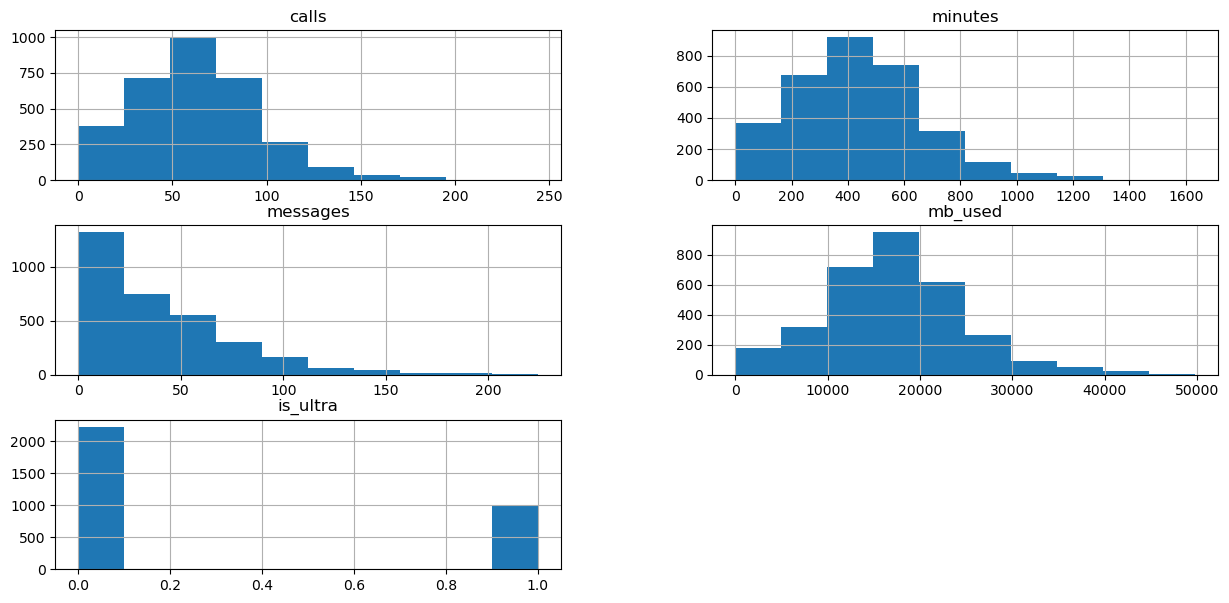

In [4]:
df.hist(figsize=(15, 7));

Предварительные выводы следующие:
1. Распределения значений -- норм, отрицательных минут, например, не обнаруено, необъяснимо больших тоже
2. Тип для calls и messages переделаем в int, но сначала проверим, все ли значения целые
3. Нужно проверить на полные дубликаты. Если найдем, то будем уже думать, что с ними делать -- само по себе совпадение строк тут не является ошибкой
4. Наименования столбцов вменяемые и в нужном формате, не трогаем
5. Незаполненных значений не нашлось

Проверим на дубликаты:

In [5]:
df.duplicated().sum()

0

Полных дубликатов нет, проверим, все ли значения целые в calls и messages

In [6]:
display(df.loc[df['calls'] % 1 > 0, :])
display(df.loc[df['messages'] % 1 > 0, :])

,calls,minutes,messages,mb_used,is_ultra


,calls,minutes,messages,mb_used,is_ultra


Значения целые, спокойно меняем типы:

In [7]:
df['calls'] = df['calls'].astype('int')
df['messages'] = df['messages'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int32  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int32  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int32(2), int64(1)
memory usage: 100.6 KB


В рамках предобработки:
- Поменяли типы на int в столбцах calls и messages

## Шаг 02. Разбейте данные на выборки

Отдельной тестовой выборки у нас нет, поэтому делим датасет на train, test и valid в пропорциях 60 - 20 - 20 соответственно.

In [8]:
data_train, data_temp = train_test_split(df, test_size=0.4, random_state=RAND_FIX) 
data_test, data_valid = train_test_split(data_temp, test_size=0.5, random_state=RAND_FIX)

display(data_train.shape)
display(data_test.shape)
display(data_valid.shape)

(1928, 5)

(643, 5)

(643, 5)

643 + 643 + 1928 = 3214, все ок.

Теперь выделяем и отрезаем целевой признак для каждой выборки:

In [9]:
features_train = data_train.drop('is_ultra', axis=1)
target_train = data_train.loc[:, 'is_ultra']

features_valid = data_valid.drop('is_ultra', axis=1)
target_valid = data_valid.loc[:, 'is_ultra']

features_test = data_test.drop('is_ultra', axis=1)
target_test = data_test.loc[:, 'is_ultra']

## Шаг 03. Исследуйте модели

Исследуем модели:
- дерево решений
- случайный лес
- логистическую регрессию

### 3.1 Дерево решений

В цикле найдем оптимальную глубину, для нее сохраним модель в best_model_for_t и посмотрим на время выполнения

In [10]:
best_model_for_t = None
best_result_for_t = 0

# Цикл для подборки глубины:
for depth in range(1, 10):
    start_time = time.time()
    model = DecisionTreeClassifier(max_depth=depth, random_state=RAND_FIX) # Инициируем модель
    model.fit(features_train, target_train)    # Учим модель
    end_time = time.time()
    result = model.score(features_valid, target_valid) # Получаем уровень схожести предсказания с target_valid
    if result > best_result_for_t:
        best_result_for_t = result
        est_time_for_t = end_time - start_time
        depth_for_result_for_t = depth
        best_model_for_t = model
        
print('Глубина для лучшей модели:', depth_for_result_for_t, end='\n\n')
print('Время выполнения для лучшей модели:', est_time_for_t)
print('Качество для лучшей модели:',best_result_for_t)

Глубина для лучшей модели: 7

Время выполнения для лучшей модели: 0.004000425338745117
Качество для лучшей модели: 0.7993779160186625


### 3.2 Случайный лес

В цикле найдем оптимальную глубину, количество деревьев, для этих параметров сохраним модель в best_model_for_f и посмотрим на время выполнения

In [11]:
best_model_for_f = None
best_result_for_f = 0
best_est_for_f = 0
best_depth_for_f = 0

# Цикл для подборки глубины и количества деревьев:
for est in range(10, 50):
    for depth in range (1, 51):
        start_time = time.time()
        model = RandomForestClassifier(random_state=RAND_FIX, n_estimators=est, max_depth=depth)  # Инициируем модель
        model.fit(features_train, target_train)     # Учим модель
        end_time = time.time()
        result = model.score(features_valid, target_valid) # Получаем уровень схожести предсказания с target_valid
        if result > best_result_for_f:
            best_model_for_f = model
            best_result_for_f = result
            best_est_for_f = est
            best_depth_for_f = depth
            est_time_for_f = end_time - start_time

print('Глубина для лучшей модели:', best_depth_for_f)
print('Количество деревьев для лучшей модели:', best_est_for_f, end='\n\n')
print('Время выполнения для лучшей модели:', est_time_for_f)
print('Качество для лучшей модели:',best_result_for_f)

Глубина для лучшей модели: 9
Количество деревьев для лучшей модели: 14

Время выполнения для лучшей модели: 0.03657245635986328
Качество для лучшей модели: 0.8149300155520995


### 3.3 Логистическая регрессия

В цикле найдем оптимальный алгоритм, для него сохраним модель в best_model_for_l и посмотрим на время выполнения

In [12]:
best_result_for_l = 0
alg = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']

# Цикл для подборки алгоритма:
for i in range(5):
    start_time = time.time()
    model = LogisticRegression(random_state=RAND_FIX, solver=alg[i], max_iter=1000)  # Инициируем модель
    model.fit(features_train, target_train)        # Учим модель
    end_time = time.time()    
    result = model.score(features_valid, target_valid) # Получаем уровень схожести предсказания с target_valid
    print('Алогритм:', alg[i])
    print('Качество:', result)
    print('Время выполнения:', end_time - start_time, end='\n\n')
    if result > best_result_for_l:
        best_result_for_l = result
        est_time_for_l = end_time - start_time
        best_alg = alg[i]
        best_model_for_l = model
        
print('Алгоритм для лучшей модели:', best_alg, end='\n\n')
print('Время выполнения для лучшей модели:', est_time_for_l)
print('Качество для лучшей модели:',best_result_for_l)

Алогритм: liblinear
Качество: 0.6889580093312597
Время выполнения: 0.005342960357666016

Алогритм: newton-cg
Качество: 0.7387247278382582
Время выполнения: 0.03369760513305664

Алогритм: lbfgs
Качество: 0.7387247278382582
Время выполнения: 0.014017581939697266

Алогритм: sag
Качество: 0.6842923794712286
Время выполнения: 0.12914037704467773

Алогритм: saga
Качество: 0.6842923794712286
Время выполнения: 0.13974213600158691

Алгоритм для лучшей модели: newton-cg

Время выполнения для лучшей модели: 0.03369760513305664
Качество для лучшей модели: 0.7387247278382582


### 3.4 Итоги сравнения

Во всех трех моделях время обучения незначительно, до 0.07 секунд.  
Наилучшее качество модели **0.815** -- у **случайного леса** с 
- Глубиной **9**
- Кочичеством деревьев **14**

## Шаг 04. Проверьте модель на тестовой выборке

Проверим модель-победитель на соответствующей тестовой выборке:

In [13]:
print('Случайный лес', best_model_for_f.score(features_test, target_test))

Случайный лес 0.7900466562986003


На тестовой выборке мы получили значение accuracy:  
**Случайный лес - 0.79**


### Общий вывод

В ходе исследования:

Получены данные о поведении клиентов. Перед тем, как приступать к целям исследования, был проведен обзор данных

Данные проверены на ошибки и оценю их влияние на исследование. Ошибок обнаружено не было, лишь только исправлены типы значений в двух колонках -- calls и messages.
Далее набор данных был разделен в соотношении 60 - 20 - 20 на обучающую, валидационную и тестовую выборки, выделен целевой признак. После этого были подобраны глобальные параметры для трех известных подходов:

- дерево решений
- случайный лес
- логистическая регрессия
  
Определен вариант с наибольшим качеством модели на валидационной выборке. После этого выводы были проверены на тестовой выборке.

Таким образом, исследование состояло из следующих этапов, на каждом из которых формировались выводы, которые попали в итоги исследования:

Обзор данных
Предобработка данных
Разбиение данных на выборки
Исследование моделей
Проверка на тестовой выборке

### Итоги исследования:

1. Лучшее качество модели было обнаружено в случае применения метода **"Случайный лес"** с 
- Глубиной **9**
- Кочичеством деревьев **14**  
На валидационной выборке к-т качества == **0.815**
2. На тестовой выборке выводы подтвердились -- метод "Случайный лес" показал лучший результат -- 0.79, что превосходит требуемый (0.75).

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 4: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
